# Preambulo

## Imports

In [323]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import time
import random
import tempfile
from sklearn.metrics import log_loss
from imblearn.over_sampling import SMOTE
import missingno
from tqdm.notebook import tqdm
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import optuna
from sklearn.metrics import f1_score
from optuna.samplers import TPESampler

## Fijación de semillas

Para poder asegurar la reproducibilidad del presente informe se fijan las semillas de los generadores de numeros aleatorios.

In [240]:
SEED = 42

# Predicción de riesgo crediticio para banco Giturra

## Introducción

El banco Giturra requiere reducir el riesgo y mejorar la calidad de sus prestamos debido a la creciente cantidad de creditos que terminan impagos. Es por esto que, para reducir el riesgo de los prestamos se desarolla un modelo de predicción del nivel del riesgo de credito de un cliente. Este recopila la información monetaria del cliente como sus ingresos o comportamiento de pagos e indica que tan riesgo seria entregar un prestamo a ese cliente. En particular, se debe poder detectar que clientes son los más probables que no pagen. Debido a esto se utilizara como metrica el recall de los clientes de alto riesgo.

## Análisis exploratorio de Datos

In [241]:
dataset = pd.read_parquet("data/dataset.pq")
dataset.head()

,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,3,...,4.0,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,0
1,CUS_0x21b1,28.0,Teacher,34847.84,3037.986667,2,4,6,1.0,3,...,2.0,605.03,32.933856,27.0,No,18.816215,218.904344,Low_spent_Small_value_payments,356.078109,0
2,CUS_0x2dbc,34.0,Engineer,143162.64,12187.220000,1,5,8,3.0,8,...,3.0,1303.01,38.374753,18.0,No,246.992319,10000.000000,High_spent_Small_value_payments,895.494583,0
3,CUS_0xb891,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,4,...,4.0,632.46,27.332515,17.0,No,16.415452,125.617251,High_spent_Small_value_payments,379.216381,0
4,CUS_0x1cdb,21.0,Developer,35547.71,2853.309167,7,5,5,-100.0,1,...,4.0,943.86,25.862922,31.0,Yes,0.000000,181.330901,High_spent_Small_value_payments,364.000016,0


In [242]:
profile = ProfileReport(dataset, title="EDA", minimal=True)
profile.to_file("profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Preparación de Datos

En esta sección se define un _pipeline_ de preprocesamiento el cual prepara los datos para su uso en las siguientes secciones. Para prevenir él _data leakage_ se comienza inmediatamente creando una separación entre los datos.

### Holdout

Se utiliza una división de train, val y test del dataset. En la siguiente celda se pueden controlar las proporciones de esta división. Se utilizó el 80% de los datos de train, 10% para validación y 10% para testing.

In [243]:
target_variable_name = "credit_score"
original_features_name = list(dataset.columns)
original_features_name.remove(target_variable_name)

x = dataset[original_features_name]
y = dataset[target_variable_name]

In [244]:
# Train: 0.8, Val: 0.1, Test: 0.1
x_train, x_other, y_train, y_other = train_test_split(x, y, test_size=0.2, random_state=SEED, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_other, y_other, test_size=0.5, random_state=SEED, stratify=y_other)


### Feature Engineering

Antes de codificar las variables y escalarlas para poder alimentar un modelo con ellas vamos a evaluar que variables podemos crear a partir de lo que significan las variables originales. Para hacer esto exploraremos las relaciones entre las variables, definiremos las nuevas variables y encapsularemos esta logica en un function transformer para poder hacerla parte del pipeline de preprocesamiento.

Dado que estamos buscando identificar aquellos clientes de alto riesgo de credito comenzaremos buscando por combinaciones de variables que se correlacionen con los clientes de alto riesgo. Partamos observando la matriz de correlaciones.

<Axes: >

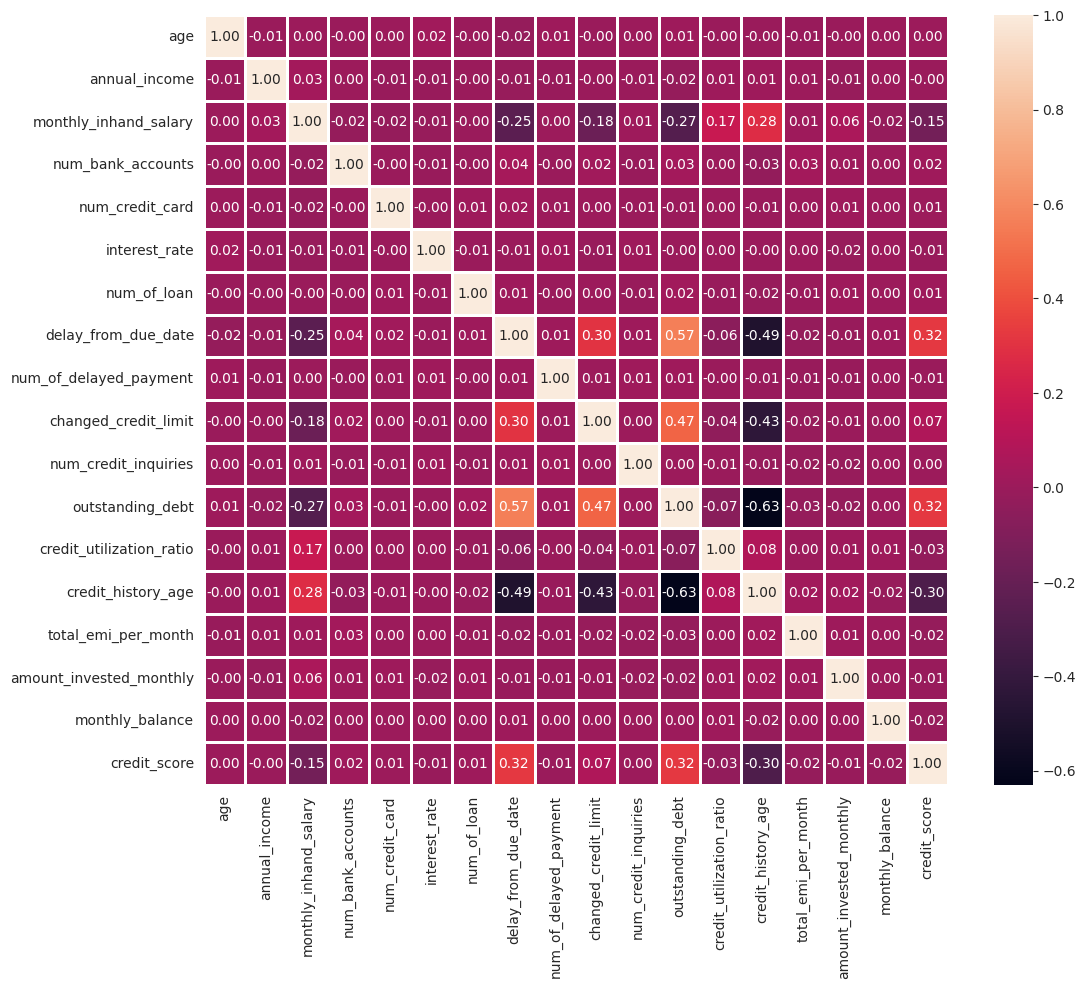

In [245]:
%matplotlib inline
train_data = pd.concat([x_train, y_train], axis=1)
corr_matrix = train_data._get_numeric_data().corr()
plt.figure(figsize = (12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=1)

Vemos que hay 4 variables con una correlación más llamativa con respecto a la variable objetivo. Tenemos que outstanding debt y delay from due date tienen una correlacion positiva mientras que credit_history_age y monthly_inhand_salary una negativa. Esto tiene sentido porque es razonable pensar que mientras más tiempo ha pasado desde la fecha de pago y mientras más se debe pagar peor va a ser el credit_score. Esto da para pensar como quedaria un modelo que utilizara solo esas 4 variables.

Vamos a explorar las variables categoricas ahora para ver si existe alguna que no sea atomica.

In [246]:
df = train_data[["occupation", "payment_of_min_amount", "payment_behaviour"]]
for col in df:
    print(df[col].unique())


['Media_Manager' 'Engineer' 'Manager' 'Developer' 'Accountant' '_______'
 'Architect' 'Mechanic' 'Doctor' 'Entrepreneur' 'Musician' 'Writer'
 'Journalist' 'Scientist' 'Teacher' 'Lawyer']
['Yes' 'No' 'NM']
['High_spent_Medium_value_payments' 'Low_spent_Large_value_payments'
 '!@9#%8' 'Low_spent_Small_value_payments'
 'High_spent_Large_value_payments' 'Low_spent_Medium_value_payments'
 'High_spent_Small_value_payments']


Tenemos valores especiales que requieren un tratamiento especial. Para occupation podriamos dejarla como esta o reemplazar '_______' por unknown. Para payment_of_min_amount yo la dejaria como esta. Para payment_behaviour yo la separaria en dos variables y las codificaria por separado y reemplazaria '!@9#%8' por null para despues intentar imputarlo por separado. Vamos a crear 3 funciones chicas que le vamos a pasar a un function transformer y luego eso al column transformer.

In [247]:
def occupation_transformer_fun(x):
    out = x.copy()
    out[out=='_______'] = np.nan
    return out.str.lower().to_frame()

occupation_transformer = FunctionTransformer(occupation_transformer_fun)

In [248]:
def payment_behaviour_transformer_fun(x):
    # This code is kinda stinky but is the end of semester and i have to 
    # finish my trabajo de titulo :( sorry!
    out = x.copy()
    out[out=='!@9#%8'] = np.nan
    out = out.str.split("_")
    out = out.to_frame()
    out['spent_size'] = out['payment_behaviour'].apply(lambda x: "_".join(x[0:2]).lower() if isinstance(x, list) else np.nan)
    out['payment_value'] = out['payment_behaviour'].apply(lambda x: "_".join(x[3::]).lower() if isinstance(x, list) else np.nan)
    out = out.drop('payment_behaviour', axis=1)
    return out

payment_behaviour_transformer = FunctionTransformer(payment_behaviour_transformer_fun)

### Preprocesamiento

En esta sección simplemente creamos el pipeline de preprocesamiento que retorna un dataframe con las variables codificadas y escaladas. 

In [249]:
categorical_variables = ["occupation", "payment_of_min_amount", "payment_behaviour"]
categorical_variables_pipeline = Pipeline([
    ('clean_variables', ColumnTransformer([
        ('occupation cleaning', occupation_transformer, "occupation"),
        ('payment_behaviour cleaning', payment_behaviour_transformer, "payment_behaviour")
    ], remainder="passthrough")),
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
numerical_variables = [
    "age", "annual_income", 'monthly_inhand_salary',
    'num_bank_accounts', 'num_credit_card',
    'interest_rate', 'num_of_loan', 'delay_from_due_date',
    'num_of_delayed_payment', 'changed_credit_limit',
    'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
    'credit_history_age', 'total_emi_per_month',
    'amount_invested_monthly', 'monthly_balance'
]
numerical_variables_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

# Primera definición del pipeline. Sin handle nulls.
preprocess_pipeline = ColumnTransformer([
    ("categorical_preprocess", categorical_variables_pipeline, categorical_variables),
    ("numerical_preprocess", numerical_variables_pipeline, numerical_variables)
]).set_output(transform="pandas")


/home/gustavo_santelices/Documents/Universidad/Primavera 2023/MDS7202/proyecto2/venv/lib/python3.8/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [250]:
x_train_transformed = preprocess_pipeline.fit_transform(x_train)
x_train_transformed.head()

,categorical_preprocess__occupation cleaning__occupation_accountant,categorical_preprocess__occupation cleaning__occupation_architect,categorical_preprocess__occupation cleaning__occupation_developer,categorical_preprocess__occupation cleaning__occupation_doctor,categorical_preprocess__occupation cleaning__occupation_engineer,categorical_preprocess__occupation cleaning__occupation_entrepreneur,categorical_preprocess__occupation cleaning__occupation_journalist,categorical_preprocess__occupation cleaning__occupation_lawyer,categorical_preprocess__occupation cleaning__occupation_manager,categorical_preprocess__occupation cleaning__occupation_mechanic,...,numerical_preprocess__delay_from_due_date,numerical_preprocess__num_of_delayed_payment,numerical_preprocess__changed_credit_limit,numerical_preprocess__num_credit_inquiries,numerical_preprocess__outstanding_debt,numerical_preprocess__credit_utilization_ratio,numerical_preprocess__credit_history_age,numerical_preprocess__total_emi_per_month,numerical_preprocess__amount_invested_monthly,numerical_preprocess__monthly_balance
605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.741079,-0.048853,0.754589,-0.108700,-0.863207,-1.051719,-1.594852,-0.154966,-0.181228,0.010139
10274,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.538873,-0.103721,-1.141700,-0.114326,-0.485398,1.036039,1.422254,-0.173030,-0.289274,0.010139
5259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.606275,-0.108293,-0.748603,-0.142456,-0.997974,-1.506553,0.939517,-0.174769,-0.166475,0.010139
11685,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.471471,-0.103721,1.272829,4.037647,0.013007,0.977384,NaN,-0.162054,4.541654,0.010139
12133,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.606963,NaN,-0.853134,-0.131204,-0.231045,-1.372242,0.698149,-0.173082,-0.245583,0.010139


### Null data Handling

En esta sección se presenta el analisis realizado para escoger la estrategia de manejo de nulls para los datos transformados. Esta logica se deja encapsulada en una pipeline de null handling. Se comenzara por ver el estado de los nulls en los datos.

<Axes: >

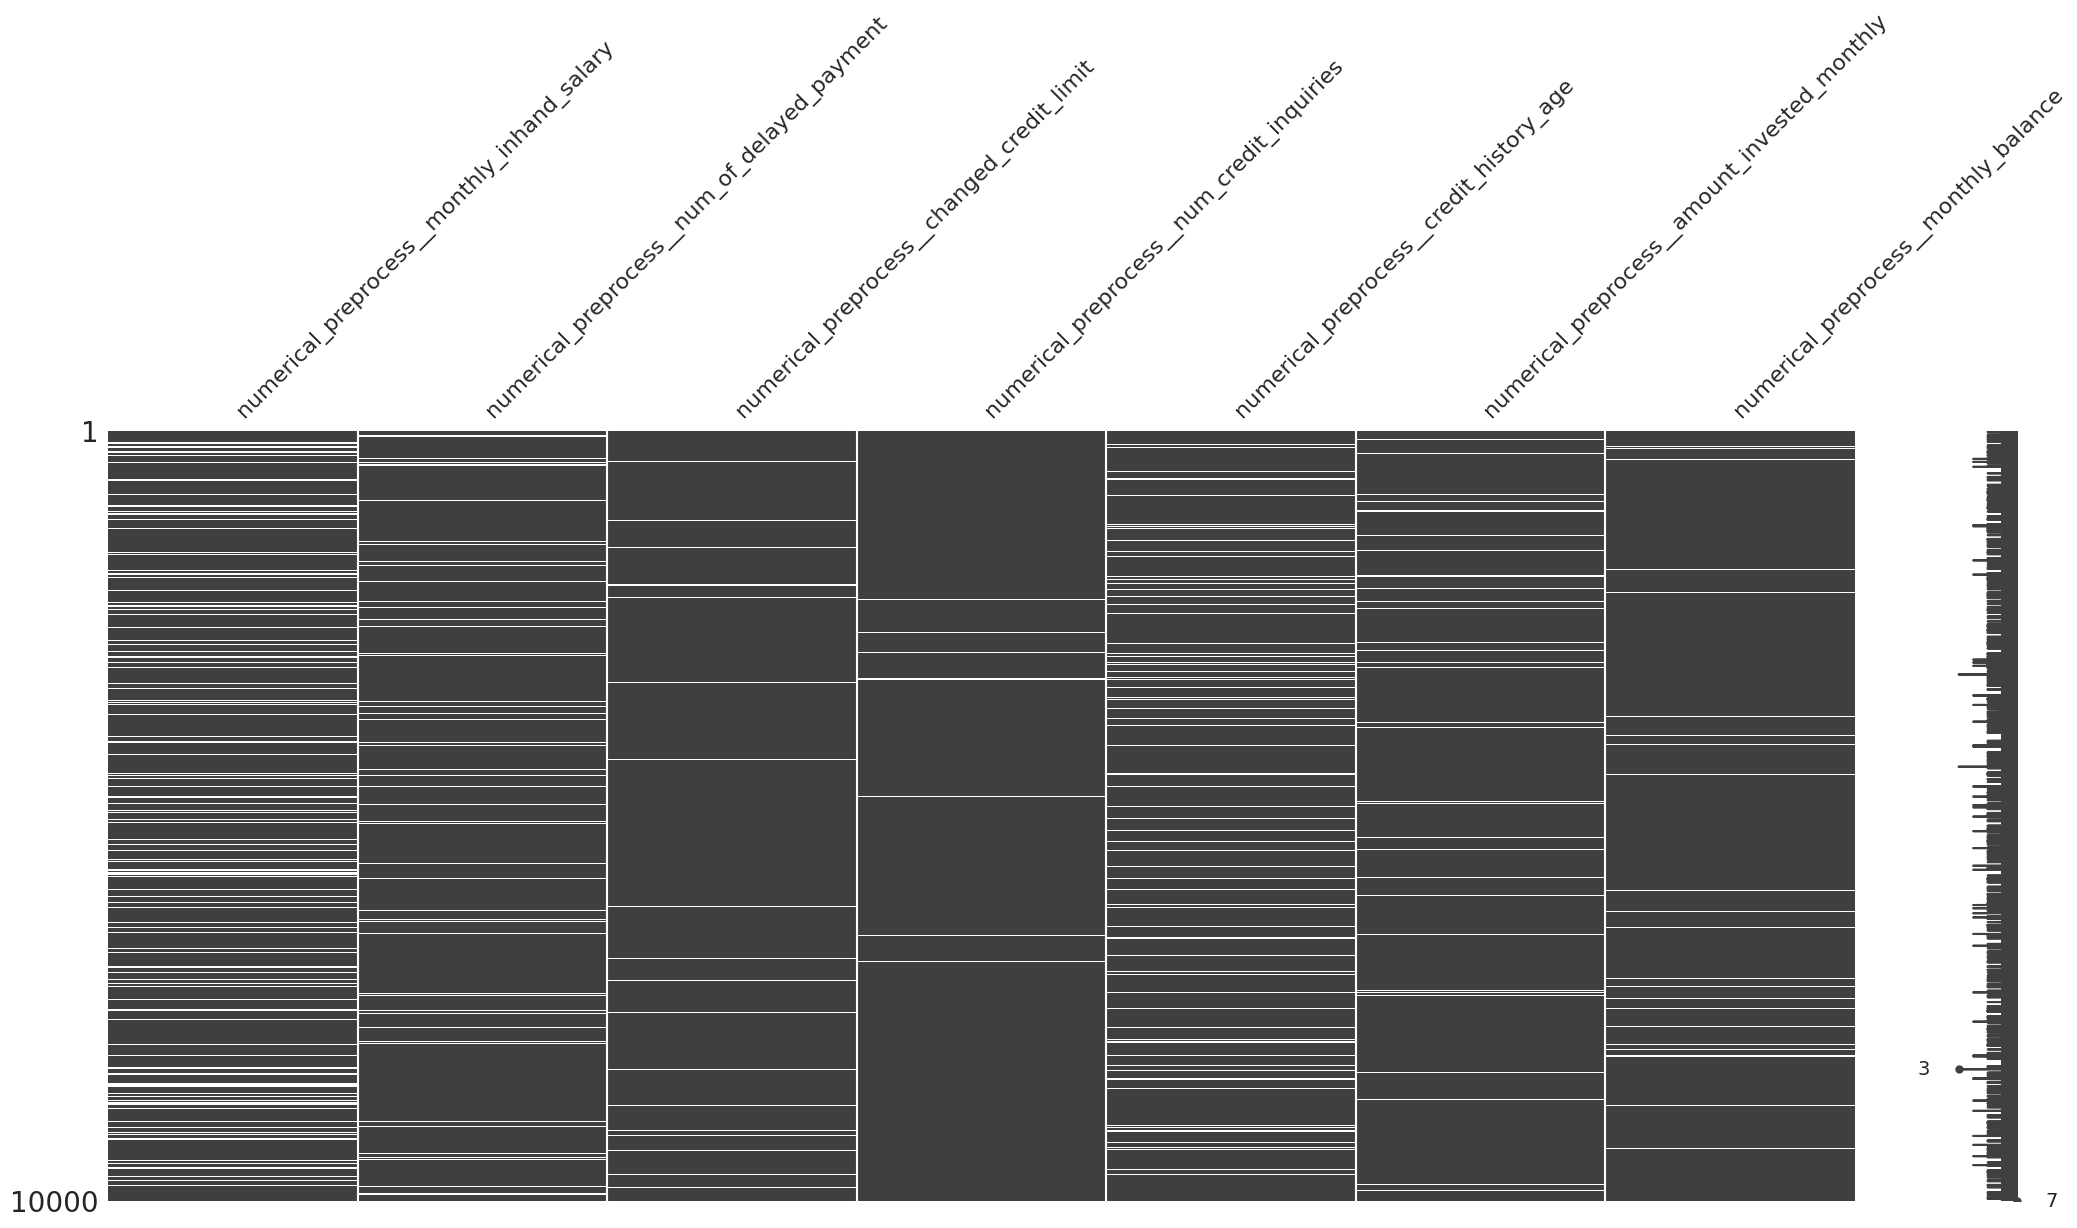

In [251]:
# Para hacer más facil de leer este grafico haremos que solo se muestren las columnas con una cantidad mayor a 0.
# El resto de columnas omitidas debe asumirse que no tiene nulls.
missingno.matrix(x_train_transformed[
                     x_train_transformed.columns[
                         x_train_transformed.isna().any(axis=0)
                     ]
                 ])

- numerical_preprocess__monthly_inhand_salary : Deberia poder aproximarse a partir de los salarios anuales. Esto lo vemos en la siguiente celda donde se ve que el percentil 25%, 50% y 75% son muy cercanos a 12. (La media es lejana a 12 pero esto se debe a outliers). Para hacer esto se va a hacer una pequeña modificación al pipeline de preprocessing ya que se requiere hacer este manejo de nulls antes de aplicar el escalamiento ya que si se hace despues se pierde la relación ya que las variables se escalan con escalas distintas (distinta media y desviación).
- numerical_preprocess__num_of_delayed_payment : Lo aproximaremos segun los K más cercanos con KNNImputer. 
- numerical_preprocess__changed_credit_limit : Lo aproximaremos segun los K más cercanos con KNNImputer.
- numerical_preprocess__num_credit_inquiries : Lo aproximaremos segun los K más cercanos con KNNImputer.
- numerical_preprocess__credit_history_age : Lo aproximaremos segun los K más cercanos con KNNImputer.
- numerical_preprocess__amount_invested_monthly : Lo aproximaremos segun los K más cercanos con KNNImputer.
- numerical_preprocess__monthly_balance : Lo aproximaremos segun los K más cercanos con KNNImputer.

En resumen se decide intentar aproximar la primera variable con nulls a partir del salario anual y el resto simplemente se asume que podremos encontrar clientes similares para poder aproximar sus variables perdidas.

In [252]:
df = x_train[['monthly_inhand_salary', 'annual_income']].copy()
df["Deberia ser 12 o cercano"] = df['annual_income'] / df['monthly_inhand_salary']
df["Deberia ser 12 o cercano"].describe()

count     8456.000000
mean        66.137667
std        869.334590
min          8.142579
25%         11.582184
50%         12.042028
75%         12.605292
max      46315.073470
Name: Deberia ser 12 o cercano, dtype: float64

In [253]:
def monthly_inhand_salary_transformer_fun(x):
    # This code is kinda stinky but is the end of semester and i have to 
    # finish my trabajo de titulo :( sorry!
    new_series = x['monthly_inhand_salary'].copy()
    new_series[new_series.isna()] = x['annual_income'] / 12
    x['monthly_inhand_salary'] = new_series
    return x

monthly_inhand_salary_transformer = FunctionTransformer(monthly_inhand_salary_transformer_fun)

In [254]:
from sklearn.impute import KNNImputer

categorical_variables = ["occupation", "payment_of_min_amount", "payment_behaviour"]
categorical_variables_pipeline = Pipeline([
    ('clean_variables', ColumnTransformer([
        ('occupation cleaning', occupation_transformer, "occupation"),
        ('payment_behaviour cleaning', payment_behaviour_transformer, "payment_behaviour")
    ], remainder="passthrough")),
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
numerical_variables = [
    "age", "annual_income", 'monthly_inhand_salary',
    'num_bank_accounts', 'num_credit_card',
    'interest_rate', 'num_of_loan', 'delay_from_due_date',
    'num_of_delayed_payment', 'changed_credit_limit',
    'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
    'credit_history_age', 'total_emi_per_month',
    'amount_invested_monthly', 'monthly_balance'
]
numerical_variables_pipeline = Pipeline([
    ('handle_nulls', monthly_inhand_salary_transformer),
    ('scaler', StandardScaler()),
])

# Esto pasa a ser hiperparametro del modelo.
N_NEIGHBORS = 3
preprocess_pipeline_with_null_handling = Pipeline([
    ('preprocess_step', ColumnTransformer([
        ("categorical_preprocess", categorical_variables_pipeline, categorical_variables),
        ("numerical_preprocess", numerical_variables_pipeline, numerical_variables)
    ])),
    ("imputer_step", KNNImputer(n_neighbors=3)),
]).set_output(transform="pandas")


/home/gustavo_santelices/Documents/Universidad/Primavera 2023/MDS7202/proyecto2/venv/lib/python3.8/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [255]:
x_train_model_ready = preprocess_pipeline_with_null_handling.fit_transform(x_train)
# Checking if there are any nulls in the resulting dataframe
x_train_model_ready.isna().any().any()

False

## Baseline

Siguiendo lo solicitado a continuación se crean las pipelines y se guardan en una lista.

In [256]:
models_name = [
    'Dummy', 'LogisticRegression', 'KNeighborsClassifier',
    'DecisionTreeClassifier', 'SVC', 'RandomForestClassifier',
    'LightGBMClassifier', 'XGBClassifier'
]

models_instance = [
    DummyClassifier(), LogisticRegression(), KNeighborsClassifier(),
    DecisionTreeClassifier(), SVC(), RandomForestClassifier(),
    LGBMClassifier(), XGBClassifier()
]

classifiers_pipelines = []

for name, instance in zip(models_name, models_instance):
    new_pipeline = Pipeline([
        ("transform_data_step", preprocess_pipeline_with_null_handling),
        ("classifier_step", instance)
    ])
    classifiers_pipelines.append(new_pipeline)
    
print("Dummy classifier pipeline")
classifiers_pipelines[0]

Dummy classifier pipeline


Pipeline(steps=[('transform_data_step',
                 Pipeline(steps=[('preprocess_step',
                                  ColumnTransformer(transformers=[('categorical_preprocess',
                                                                   Pipeline(steps=[('clean_variables',
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('occupation '
                                                                                                                     'cleaning',
                                                                                                                     FunctionTransformer(func=<function occupation_transformer_fun at 0x7f393e74fe50>),
                                                                                                                     'occupation'),
                                                                                                                    ('payment_...
                                                                    'num_credit_card',
                                                                    'interest_rate',
                                                                    'num_of_loan',
                                                                    'delay_from_due_date',
                                                                    'num_of_delayed_payment',
                                                                    'changed_credit_limit',
                                                                    'num_credit_inquiries',
                                                                    'outstanding_debt',
                                                                    'credit_utilization_ratio',
                                                                    'credit_history_age',
                                                                    'total_emi_per_month',
                                                                    'amount_invested_monthly',
                                                                    'monthly_balance'])])),
                                 ('imputer_step', KNNImputer(n_neighbors=3))])),
                ('classifier_step', DummyClassifier())])

In [257]:
dataset

,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,3,...,4.0,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,0
1,CUS_0x21b1,28.0,Teacher,34847.84,3037.986667,2,4,6,1.0,3,...,2.0,605.03,32.933856,27.0,No,18.816215,218.904344,Low_spent_Small_value_payments,356.078109,0
2,CUS_0x2dbc,34.0,Engineer,143162.64,12187.220000,1,5,8,3.0,8,...,3.0,1303.01,38.374753,18.0,No,246.992319,10000.000000,High_spent_Small_value_payments,895.494583,0
3,CUS_0xb891,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,4,...,4.0,632.46,27.332515,17.0,No,16.415452,125.617251,High_spent_Small_value_payments,379.216381,0
4,CUS_0x1cdb,21.0,Developer,35547.71,2853.309167,7,5,5,-100.0,1,...,4.0,943.86,25.862922,31.0,Yes,0.000000,181.330901,High_spent_Small_value_payments,364.000016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,CUS_0x372c,19.0,Lawyer,42903.79,3468.315833,0,4,6,1.0,9,...,1.0,1079.48,35.716618,28.0,No,34.975457,115.184984,High_spent_Medium_value_payments,NaN,0
12496,CUS_0xf16,45.0,Media_Manager,16680.35,NaN,1,1,5,4.0,1,...,8.0,897.16,41.212367,NaN,No,41.113561,70.805550,Low_spent_Large_value_payments,NaN,0
12497,CUS_0xaf61,50.0,Writer,37188.10,3097.008333,1,4,5,3.0,7,...,3.0,620.64,39.300980,30.0,No,84.205949,42.935566,High_spent_Medium_value_payments,NaN,0
12498,CUS_0x8600,29.0,Architect,20002.88,1929.906667,10,8,29,5.0,33,...,9.0,3571.70,37.140784,6.0,Yes,60.964772,34.662906,High_spent_Large_value_payments,NaN,0


In [258]:
reports = {}
for name, pipe in zip(models_name, classifiers_pipelines):
    metrics = {}
    pipe.fit(x_train, y_train)
    metrics["train"] = classification_report(
        y_train, pipe.predict(x_train),
        output_dict=True, zero_division=0.0
    )
    metrics["val"] = classification_report(
        y_val, pipe.predict(x_val),
        output_dict=True, zero_division=0.0
    )
    reports[name]=metrics

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2882, number of negative: 7118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288200 -> initscore=-0.904142
[LightGBM] [Info] Start training from score -0.904142


In [268]:
# Este codigo se lo pedi a chatGPT! Heads up!
# Create an empty DataFrame
df_list = []

# Iterate through the models and their metrics
for model_name, metrics in reports.items():
    for dataset, dataset_metrics in metrics.items():
        # Flatten the nested dictionary
        flat_metrics = {}
        for key, value in dataset_metrics.items():
            if isinstance(value, dict):
                flat_metrics.update({f"{key}_{k}": v for k, v in value.items()})
            else:
                flat_metrics[key] = value

        # Add model and dataset information
        flat_metrics['Model'] = model_name
        flat_metrics['Dataset'] = dataset

        # Append the flattened metrics to the DataFrame list
        df_list.append(flat_metrics)

# Specify the order of columns
desired_columns_order = [
    'Model', 'Dataset',  'accuracy',
    'weighted avg_precision', 'weighted avg_recall', 'weighted avg_f1-score', 'weighted avg_support',
    'macro avg_precision', 'macro avg_recall', 'macro avg_f1-score', 'macro avg_support',
    '0_precision', '0_recall', '0_f1-score', '0_support',
    '1_precision', '1_recall', '1_f1-score', '1_support',
]

# Create the DataFrame with the specified column order
df = pd.DataFrame(df_list)[desired_columns_order]

df = df.sort_values(by=['weighted avg_precision', 'weighted avg_recall'], ascending=False)

# Display the DataFrame
df.loc[df.Dataset=="val"]


,Model,Dataset,accuracy,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support
13,LightGBMClassifier,val,0.7872,0.778239,0.7872,0.780018,1250.0,0.743319,0.712438,0.724043,1250.0,0.825678,0.888764,0.856061,890.0,0.660959,0.536111,0.592025,360.0
11,RandomForestClassifier,val,0.7848,0.774518,0.7848,0.775574,1250.0,0.741688,0.703308,0.716659,1250.0,0.819116,0.895506,0.855609,890.0,0.664260,0.511111,0.577708,360.0
15,XGBClassifier,val,0.7656,0.752876,0.7656,0.754953,1250.0,0.714119,0.678246,0.690094,1250.0,0.805527,0.884270,0.843064,890.0,0.622711,0.472222,0.537125,360.0
9,SVC,val,0.7528,0.733712,0.7528,0.727904,1250.0,0.701898,0.632865,0.644919,1250.0,0.776930,0.915730,0.840640,890.0,0.626866,0.350000,0.449198,360.0
5,KNeighborsClassifier,val,0.7344,0.717334,0.7344,0.721472,1250.0,0.668176,0.638140,0.646994,1250.0,0.784114,0.865169,0.822650,890.0,0.552239,0.411111,0.471338,360.0
3,LogisticRegression,val,0.7344,0.711400,0.7344,0.712466,1250.0,0.667232,0.619117,0.628228,1250.0,0.771401,0.891011,0.826903,890.0,0.563063,0.347222,0.429553,360.0
7,DecisionTreeClassifier,val,0.6944,0.693895,0.6944,0.694146,1250.0,0.627014,0.626592,0.626800,1250.0,0.784753,0.786517,0.785634,890.0,0.469274,0.466667,0.467967,360.0
1,Dummy,val,0.7120,0.506944,0.7120,0.592224,1250.0,0.356000,0.500000,0.415888,1250.0,0.712000,1.000000,0.831776,890.0,0.000000,0.000000,0.000000,360.0


- ¿Hay algún clasificador entrenado mejor que el azar (`Dummy`)?
Si, todos tienen mejor accuracy y weighted avg_f1-score.

- ¿Cuál es el mejor clasificador entrenado?}
Es LightGBMClassifier el que tiene mayor accuracy y weighted avg_f1-score.

- ¿Por qué el mejor clasificador es mejor que los otros?
Al evaluar la accuracy y weighted avg_f1-score es el que mejores metricas obtiene. En general los modelos de arboles parecen ser muy capaces de resolver bien este problema.

- Respecto al tiempo de entrenamiento, con cual cree que sería mejor experimentar (piense en el tiempo que le tomaría pasar el modelo por una grilla de optimización de hiperparámetros).
Se estima que el mejor modelo para optimizar es LGBMClassifier ya que es liviano y rapido de entrenar y tiene muchos hiperparametros para ajustar.

## Optimización del Modelo

Antes de comenzar a optimizar un modelo vamos a escribir un poco de boilerplate para preparar las optimizaciones.

In [276]:
# variable para guardar el mejor pipe mediante un callback
best_pipe = None
# variable para guardar el modelo actual y tomarlo desde aqui en un callback
curr_pipe = None

In [277]:
def callback(study, trial):
    global best_pipe
    if study.best_trial == trial:
        best_pipe = curr_pipe

In [299]:
def objective_function_LGBMClassifier(trial):
    global curr_pipe

    # Define the hyperparameters to tune
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_leaves": trial.suggest_int("max_leaves", 0, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "random_state": SEED,
        "verbosity": -1,
    }

    trial_pipe = Pipeline([
        ("transform_data_step", preprocess_pipeline_with_null_handling),
        ("classifier_step", LGBMClassifier(**params))
    ])
    
    curr_pipe = trial_pipe

    trial_pipe.fit(x_train, y_train)
    trial_y_val_pred = trial_pipe.predict(x_val)

    loss = 1 - f1_score(y_val, trial_y_val_pred, average="weighted")

    return loss

In [300]:
def objective_function_RandomForestClassifier(trial):
    global curr_pipe

    # Define the hyperparameters to tune
    params = {
        "n_estimators":trial.suggest_int('n_estimators', 10, 100),
        "max_depth": trial.suggest_int('max_depth', 2, 32),
        "min_samples_split": trial.suggest_float('min_samples_split', 0.1, 1.0),
        "min_samples_leaf":trial.suggest_float('min_samples_leaf', 0.1, 0.5),
        "random_state": SEED,
    }

    trial_pipe = Pipeline([
        ("transform_data_step", preprocess_pipeline_with_null_handling),
        ("classifier_step", RandomForestClassifier(**params))
    ])

    curr_pipe = trial_pipe

    trial_pipe.fit(x_train, y_train)
    trial_y_val_pred = trial_pipe.predict(x_val)

    loss = 1 - f1_score(y_val, trial_y_val_pred, average="weighted")

    return loss

### Optimizando LGBMClassifier

In [301]:
study_LGBMClassifier = optuna.create_study(sampler=TPESampler(seed=SEED))
study_LGBMClassifier.optimize(objective_function_LGBMClassifier, timeout =60 * 5, callbacks=[callback])

[I 2023-12-18 23:15:51,364] A new study created in memory with name: no-name-b1b6d190-d08b-475a-92e4-9c54f54fb5be
[I 2023-12-18 23:15:56,708] Trial 0 finished with value: 0.2164663910230371 and parameters: {'learning_rate': 0.005611516415334507, 'n_estimators': 954, 'max_depth': 8, 'max_leaves': 60, 'min_child_weight': 1}. Best is trial 0 with value: 0.2164663910230371.
[I 2023-12-18 23:15:59,521] Trial 1 finished with value: 0.4077757009345795 and parameters: {'learning_rate': 0.002051110418843397, 'n_estimators': 105, 'max_depth': 9, 'max_leaves': 60, 'min_child_weight': 4}. Best is trial 0 with value: 0.2164663910230371.
[I 2023-12-18 23:16:03,904] Trial 2 finished with value: 0.22726073508736688 and parameters: {'learning_rate': 0.0010994335574766201, 'n_estimators': 972, 'max_depth': 9, 'max_leaves': 21, 'min_child_weight': 1}. Best is trial 0 with value: 0.2164663910230371.
[I 2023-12-18 23:16:06,874] Trial 3 finished with value: 0.26388324010260533 and parameters: {'learning_rat

In [312]:
# Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
best_pipe_LGBMClassifier = best_pipe
val_error_study_LGBMClassifier = study_LGBMClassifier.best_trial.values[0]
print("Numero de trials: ", len(study_LGBMClassifier.trials))
print("Mejor F1: ", 1 - study_LGBMClassifier.best_trial.values[0])
print("Mejores hiperparámetros: ", study_LGBMClassifier.best_params)

Numero de trials:  85
Mejor F1:  0.7896292817232166
Mejores hiperparámetros:  {'learning_rate': 0.016409286730647923, 'n_estimators': 212, 'max_depth': 3, 'max_leaves': 95, 'min_child_weight': 5}


In [303]:
y_pred = best_pipe_LGBMClassifier.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.86       890
           1       0.70      0.53      0.60       360

    accuracy                           0.80      1250
   macro avg       0.76      0.72      0.73      1250
weighted avg       0.79      0.80      0.79      1250


### Optimizando RandomForestClassifier

In [305]:
study_RandomForestClassifier = optuna.create_study(sampler=TPESampler(seed=SEED))
study_RandomForestClassifier.optimize(objective_function_RandomForestClassifier, timeout =60 * 2, callbacks=[callback])

[I 2023-12-18 23:25:29,092] A new study created in memory with name: no-name-4908793e-e6c0-49f0-b58a-229320e4f66d
[I 2023-12-18 23:25:33,097] Trial 0 finished with value: 0.4077757009345795 and parameters: {'n_estimators': 44, 'max_depth': 31, 'min_samples_split': 0.7587945476302645, 'min_samples_leaf': 0.3394633936788146}. Best is trial 0 with value: 0.4077757009345795.
[I 2023-12-18 23:25:35,656] Trial 1 finished with value: 0.4077757009345795 and parameters: {'n_estimators': 24, 'max_depth': 6, 'min_samples_split': 0.15227525095137953, 'min_samples_leaf': 0.4464704583099741}. Best is trial 0 with value: 0.4077757009345795.
[I 2023-12-18 23:25:38,284] Trial 2 finished with value: 0.4077757009345795 and parameters: {'n_estimators': 64, 'max_depth': 23, 'min_samples_split': 0.1185260448662222, 'min_samples_leaf': 0.4879639408647978}. Best is trial 0 with value: 0.4077757009345795.
[I 2023-12-18 23:25:41,112] Trial 3 finished with value: 0.4077757009345795 and parameters: {'n_estimators

In [313]:
# Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
best_pipe_RandomForestClassifier = best_pipe
val_error_study_RandomForestClassifier = study_RandomForestClassifier.best_trial.values[0]
print("Numero de trials: ", len(study_RandomForestClassifier.trials))
print("Mejor F1: ", 1 - study_RandomForestClassifier.best_trial.values[0])
print("Mejores hiperparámetros: ", study_RandomForestClassifier.best_params)

Numero de trials:  44
Mejor F1:  0.5922242990654205
Mejores hiperparámetros:  {'n_estimators': 44, 'max_depth': 31, 'min_samples_split': 0.7587945476302645, 'min_samples_leaf': 0.3394633936788146}


In [330]:
y_pred = best_pipe_RandomForestClassifier.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       890
           1       0.00      0.00      0.00       360

    accuracy                           0.71      1250
   macro avg       0.36      0.50      0.42      1250
weighted avg       0.51      0.71      0.59      1250


/home/gustavo_santelices/Documents/Universidad/Primavera 2023/MDS7202/proyecto2/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gustavo_santelices/Documents/Universidad/Primavera 2023/MDS7202/proyecto2/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gustavo_santelices/Documents/Universidad/Primavera 2023/MDS7202/proyecto2/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set 

Se usa LGBMClassifier ya que mejoro levemente al optimizar sus hiperparametros. A continuación se prueba incluir SMOTE en la pipeline del study para ver si se puede intentar mejorar aun mas el weighted f1.

### Imbalanced Learn

In [326]:
def objective_function_LGBMClassifier_with_SMOTE(trial):
    global curr_pipe

    # Define the hyperparameters to tune
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_leaves": trial.suggest_int("max_leaves", 0, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "random_state": SEED,
        "verbosity": -1,
    }
    # Break the pipeline in order to use smote
    
    preprocess_pipeline_ = clone(preprocess_pipeline_with_null_handling)
    x_train_transformed_, y_train_transformed_ = preprocess_pipeline_.fit_transform(x_train), y_train
    
    smote = SMOTE(sampling_strategy='auto', random_state=SEED)
    x_resampled, y_resampled = smote.fit_resample(x_train_transformed_, y_train_transformed_)
    
    model = LGBMClassifier(**params)
    model.fit(x_resampled, y_resampled)

    trial_pipe = Pipeline([
        ("transform_data_step", preprocess_pipeline_),
        ("classifier_step", model)
    ])

    curr_pipe = trial_pipe

    trial_y_val_pred = trial_pipe.predict(x_val)

    loss = 1 - f1_score(y_val, trial_y_val_pred, average="weighted")

    return loss

In [328]:
study_LGBMClassifier_with_SMOTE = optuna.create_study(sampler=TPESampler(seed=SEED))
study_LGBMClassifier_with_SMOTE.optimize(objective_function_LGBMClassifier_with_SMOTE, timeout =60 * 5, callbacks=[callback])

[I 2023-12-18 23:47:51,492] A new study created in memory with name: no-name-f65b9b2d-35a2-4599-9c32-6b51cc4e5702
[I 2023-12-18 23:48:01,008] Trial 0 finished with value: 0.2163700935745776 and parameters: {'learning_rate': 0.005611516415334507, 'n_estimators': 954, 'max_depth': 8, 'max_leaves': 60, 'min_child_weight': 1}. Best is trial 0 with value: 0.2163700935745776.
[I 2023-12-18 23:48:05,553] Trial 1 finished with value: 0.23423931076189164 and parameters: {'learning_rate': 0.002051110418843397, 'n_estimators': 105, 'max_depth': 9, 'max_leaves': 60, 'min_child_weight': 4}. Best is trial 0 with value: 0.2163700935745776.
[I 2023-12-18 23:48:14,758] Trial 2 finished with value: 0.231770515970516 and parameters: {'learning_rate': 0.0010994335574766201, 'n_estimators': 972, 'max_depth': 9, 'max_leaves': 21, 'min_child_weight': 1}. Best is trial 0 with value: 0.2163700935745776.
[I 2023-12-18 23:48:21,221] Trial 3 finished with value: 0.231063184514273 and parameters: {'learning_rate':

In [333]:
# Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
best_pipe_LGBMClassifier_with_SMOTE = best_pipe
val_error_study_LGBMClassifier_with_SMOTE = study_LGBMClassifier_with_SMOTE.best_trial.values[0]
print("Numero de trials: ", len(study_LGBMClassifier_with_SMOTE.trials))
print("Mejor logloss: ", study_LGBMClassifier_with_SMOTE.best_trial.values[0])
print("Mejores hiperparámetros: ", study_LGBMClassifier_with_SMOTE.best_params)

Numero de trials:  54
Mejor logloss:  0.21029070492825963
Mejores hiperparámetros:  {'learning_rate': 0.015807543954609076, 'n_estimators': 376, 'max_depth': 9, 'max_leaves': 49, 'min_child_weight': 4}


In [334]:
y_pred = best_pipe_LGBMClassifier_with_SMOTE.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       890
           1       0.65      0.59      0.62       360

    accuracy                           0.79      1250
   macro avg       0.75      0.73      0.74      1250
weighted avg       0.79      0.79      0.79      1250


El resultado fue basicamente el mismo, me la impresión que puede ser que mis caracteristicas no sean lo suficientemente fuertes para poder obtener mejores resultados o que los rangos de los hiperparametros son malos. Pero dado constraints de tiempo tengo que dejar este analisis hasta aca.

In [348]:
# Probemos sobre test el ultimo modelo que en teoria al tener SMOTE deberia generalizar mejor
y_pred = best_pipe_LGBMClassifier_with_SMOTE.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       890
           1       0.63      0.61      0.62       360

    accuracy                           0.78      1250
   macro avg       0.74      0.73      0.73      1250
weighted avg       0.78      0.78      0.78      1250


Bastante bien! Los resultados de test son muy similares a los previamente obtenidos asi que el modelo es capaz de generalizar.

### Visualización con Optuna

## Interpretabilidad

Usaremos los SHAP values, necesitamos identificar que variables son las que más aportan a discriminar el credit score. Se espera que estas variables sean las relacionadas al comportamiento de credito del cliente como la deuda que tenga o cuantas tarjetas de credito tenga. Es importante comprender cuales son las variables que influyen en la desición del modelo para evitar existan sesgos dañinos como segregar por genero.

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


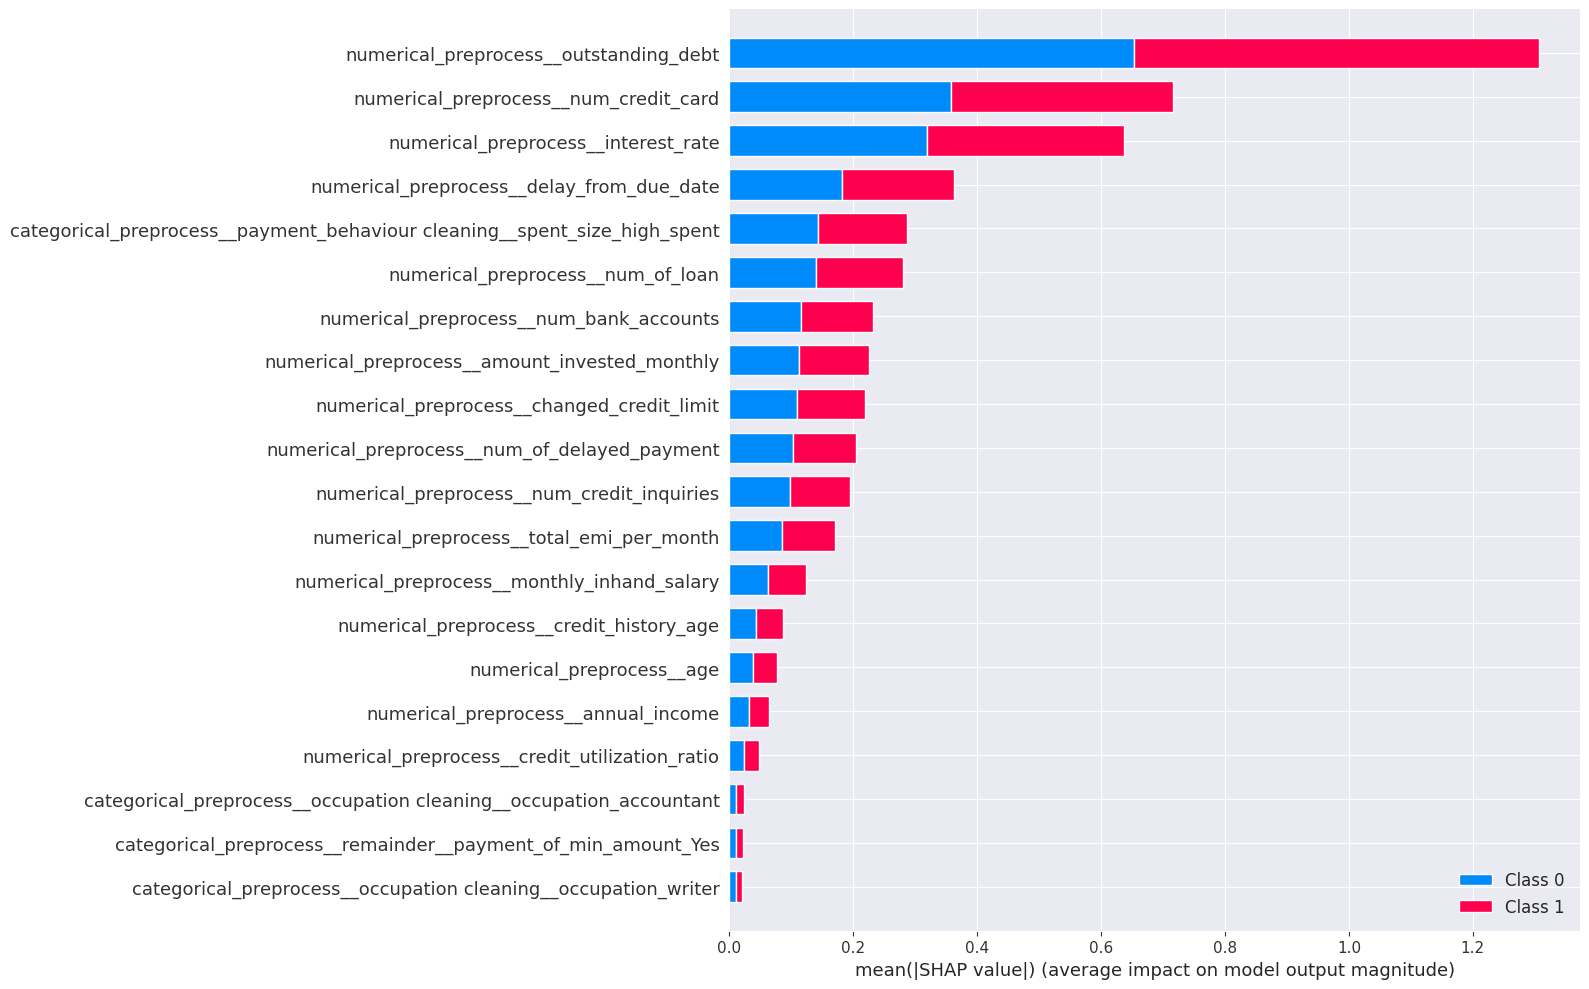

In [356]:
explainer = shap.TreeExplainer(best_pipe_LGBMClassifier_with_SMOTE[-1])
shap_values = explainer.shap_values(x_train_transformed)

# Malditos nombres largos de las variables
shap.summary_plot(shap_values, x_train_transformed, max_display=20, plot_size=(16, 10))


Se puede ver que el modelo considera como más importantes variables que van relacionadas al comportamiento de credito del cliente que es lo que se requeria y ademas es la intución más logica. La importancia de la variables disminuye rapidamente a medida que dejan de relacionarse con el comportamiento de pagos del cliente. Hay variables muy irrelevantes como la profesión del cliente o cuanto ha utilizado de su credito.

## Conclusiones

Se pudo obtener un modelo que satisfactoriamente logra discriminar clientes de alto riesgo de credito, fue interesante probar distintas tecnicas de preprocesamiento, modelado y optimización de modelos. Queda pendiente poder entender a mayor detalle el funcionamiento interno de cada tecnica utilizada. Actualmente se sabe a nivel más macroscopico como funcionan todas estas herramientas y debido a lo rapido que se mueve el area es dificil poder ahondar mucho a todas las tecnicas. 

La optimización del modelo fue poco efectiva, queda pendiente descubrir la razon. El preprocesamiento probo ser bastante util para limpiar y preparar los datos. El uso de pipelines se aprecia bastante para evitar el dataleakage. Fue una pena tener que dejar de usar Pipelines para poder hacer uso de SMOTE. Queda pendiente explorar como hacer esto de mejor manera.

Con respcto a la interpretabilidad es muy util usar modelos de arboles pues son muy comodos para explorar su funcionamiento con varios metodos como los valores SHAP, la feature importance y usar librerias como eli5.
 

----

# Bonus

### Probando PyCaret

## Packaging con Kedro

## API del modelo con FastAPI